# **Deep Fake Face Image Generator using DeepImagify-GAN.**

# **Mounting Google Drive locally**

This only supports reading, writing, and moving files; to programmatically modify sharing settings or other metadata, use one of the other options below.

Note: When using the 'Mount Drive' button in the file browser, no authentication codes are necessary for notebooks that have only been edited by the current user.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Importing Necessary Libraries needed for building GANs for Deep Face Image Generation**

In [ ]:
# TensorFlow is a free and open-source software library for machine learning and artificial intelligence. 
# It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


# Keras is an open-source software library that provides a Python interface for artificial neural networks. 
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import *

# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np

# Python Imaging Library is a free and open-source additional library for the Python programming language 
# It adds support for opening, manipulating, and saving many different image file formats.
from PIL import Image
from tqdm import tqdm

# Importing Operating system related basic functionalities
import os 
import time

# Visualization for images
import matplotlib.pyplot as plt

# Reading different file format to extract and maintain them in local
import zipfile

# pandas is a software library written for the Python programming language for data manipulation and analysis. 
# In particular, it offers data structures and operations for manipulating numerical tables and time series.
import pandas as pd

# **Data Loading**

# **Loading the image data with zipfile**

# **Dataset**

CelebFaces Attributes (CelebA) Dataset. Face recognition is a major component of computer vision and deep learning, with applications ranging from login into your phone with your face to looking through surveillance photographs for a specific suspect.

In [ ]:
# Reading the data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/img_align_celeba.zip", 'r')

# Extracting the Data
zip_ref.extractall("/tmp")

# Closing the file operation after closing
zip_ref.close()

# **Data Pre-Processing**

The properties and preprocessing are as follows: Image count is locked at 10,000 for training as the GPU in Google Colab will not support the entire 200,000 images for training. The original image height and width are 208 * 178 * 3 dimensions. The difference between the dimensions is calculated by subtracting the original height from the original width and performing floor division on the difference. The height and width of the images are adjusted to 128 * 128 * 3 dimensions cropping based on the floor division result. All images are converted to UINT8 format from the NumPy library which is an 8-bit unassigned integer ranging from 0-255 decimals values.

In [ ]:
PIC_DIR = f'/tmp/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open('/tmp/img_align_celeba/' + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:23<00:00, 418.34it/s]


In the final step, all the images using the NumPy array are divided by the float value 255.0 for converting to the least possible value for mathematical calculations.

In [ ]:
# Converting to the least possible values for mathematical calculations
images = np.array(images) / 255

# Defining the shape
print(images.shape)

(10000, 128, 128, 3)


A short glimpse of the sample images from the dataset for understanding the image properties.

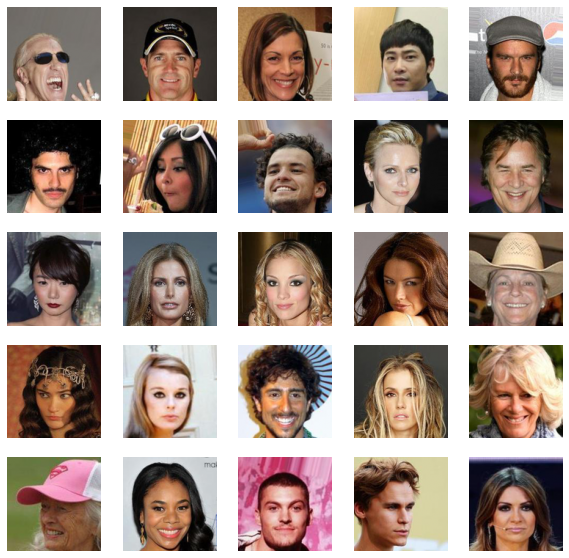

In [ ]:
plt.figure(1, figsize=(10, 10))
# Taking random photos from the dataset
for i in range(25,50):
    j=i-25
    plt.subplot(5, 5, j+1)
    plt.imshow(images[i])
    plt.axis('off')
    # Showing the images
plt.show()

# **Model Development**

Deep Fake Face Image Generator using DeepImagify-GAN.

To develop Deep Fake Face Image Generation, the system is trained to generate images based on the training from celebrities’ image data set using Generative Adversarial Networks. A custom build GAN is used to do the task. GAN is named Deep-Imagify GAN. It is built on encoder-decoder-based architecture.

In [1]:
# Defininf the seed size
SEED_SIZE = 32

# Channels RGB
CHANNELS = 3

In a nutshell, we'll tell the generator to make faces without providing any extra information. Simultaneously, we'll provide the discriminator of the existing faces in the dataset and ask it to determine whether the images generated by the Generator are authentic. Initially, the Generator will produce poor photos that the Discriminator will immediately flag as wrong with a lower confidence score along with deviation.
As a result of the decreased deviation from the true photos, the Generator will learn to fool the Discriminator after receiving enough data from it. As a result, we'll have a really good generative model that can produce very realistic results.

The generator reverses the situation: it is attempting to deceive the discriminator. There are eight convolutional layers in this network. First, we take our gen input and feed it into our first convolutional layer. Each convolutional layer first executes a convolution, followed by batch normalization and a leaky ReLU. The tanh activation function is then returned.

In [ ]:
def create_generator():
    gen_input = Input(shape=(SEED_SIZE, ))

    # Dense layer is the regular deeply connected neural network layer. 
    x = Dense(128 * 16 * 16)(gen_input)

    # Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. 
    x = LeakyReLU()(x)

    # Reshaping the image
    x = Reshape((16, 16, 128))(x)

    # Keras Conv2D is a 2D Convolution layer. 
    # This creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
    x = Conv2D(256, 5, padding='same')(x)

     # Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. 
    x = LeakyReLU()(x)

    # Transposed convolution layer (sometimes called Deconvolution).
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)

    # Defining the activation
    x = LeakyReLU()(x)

    # Deconvolution
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)

    # Defining the activation
    x = LeakyReLU()(x)

    # Deconvolution
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)

    # Defining the activation
    x = LeakyReLU()(x)

    # Keras Conv2D is a 2D Convolution layer. 
    x = Conv2D(512, 5, padding='same')(x)

    # Defining the activation
    x = LeakyReLU()(x)

    # Convolution layer
    x = Conv2D(512, 5, padding='same')(x)

    # Defining the activation
    x = LeakyReLU()(x)
    
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    # Defininf the Model for generated layers and input data
    generator = Model(gen_input, x)
    return generator

The discriminator network, like the generator, is made up of convolutional layers. Convolution will be applied to each layer of the network, followed by batch normalization to make the network quicker and more accurate, and lastly a Leaky ReLU.

In [ ]:
def create_discriminator():
    # Defininf the layers
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

     # Convolution layer
    x = Conv2D(256, 3)(disc_input)
    # Defining the activation
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    # Defining the activation
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    # Defining the activation
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    # Defining the activation
    x = LeakyReLU()(x)

    # Convolution layer
    x = Conv2D(256, 4, strides=2)(x)
    # Defining the activation
    x = LeakyReLU()(x)
  
    # Defining the Flatten Layer
    x = Flatten()(x)

    # Adding Dropout for regularizing and resetting the weights
    x = Dropout(0.4)(x)

    # Final Dense Layer
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

# **Initializing the Generator**

In [ ]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

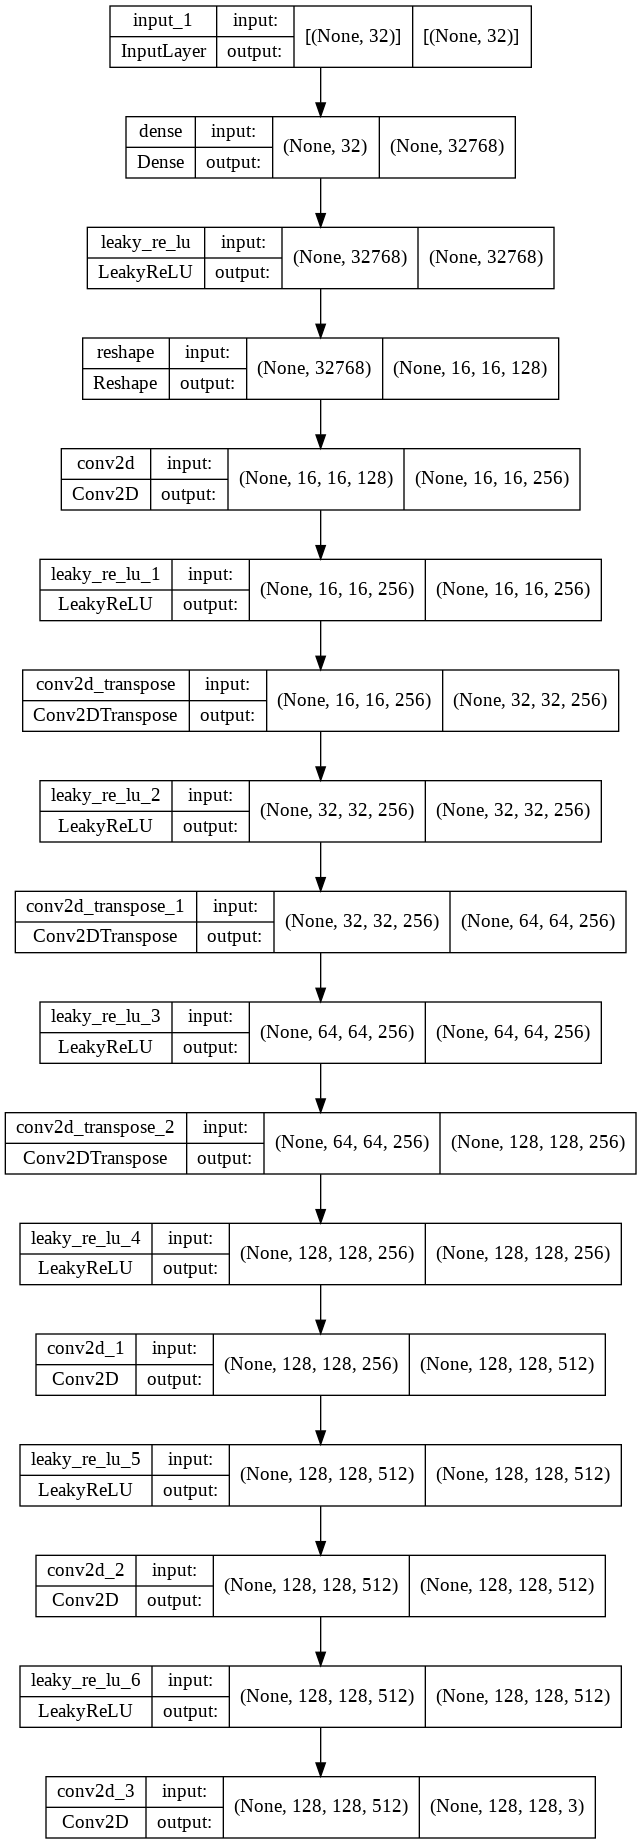

In [ ]:
# Model Summary for Generator
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

# **Initializing the Discriminator**

In [ ]:

discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


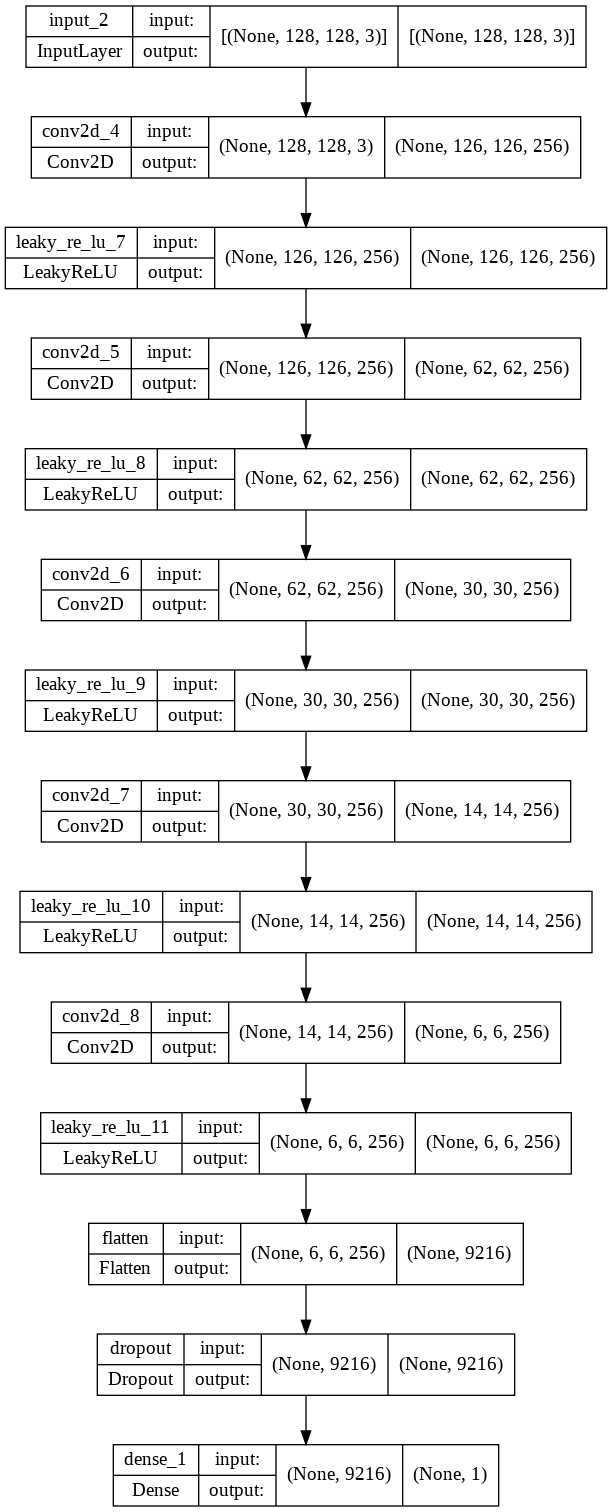

In [ ]:
# Model Summary for Discriminator
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

# **Defining the GAN INPUT and Preparing the Final Model**

In [ ]:
# Defininf the Gan INPUT
gan_input = Input(shape=(SEED_SIZE, ))

# Disc and Generator for Gan Input
gan_output = discriminator(generator(gan_input))

# Final GAN Model
gan = Model(gan_input, gan_output)

# **Defining the final GAN Optimizers and Compilation method**

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
gan.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_3 (Functional)        (None, 128, 128, 3)       14953987  
                                                                 
 model_4 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [ ]:
import time

# Defining the Batch Iterations
iters = 3618

# Batch Size
batch_size = 20

GENERATED_IMAGES_PATH = 'GeneratedImages'
FILE_PATH = '%s/generated_%d.png'
# Images Path
os.mkdir(GENERATED_IMAGES_PATH)

control_vectors = np.random.normal(size=(1, SEED_SIZE)) / 2

start = 0

# list to collect loss for the discriminator model
d_losses = [] 
# list to collect loss for generator model
a_losses = []
count=0
images_saved = 0
 # For every iteration in the dataset
for step in range(iters):
    print(count)
    count+=1
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, SEED_SIZE))
    generated = generator.predict(latent_vectors)

    #train on real image
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    # train on fake image
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, SEED_SIZE))
    misleading_targets = np.zeros((batch_size, 1))

    # train the generator
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > 9984:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/tmp/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        control_image = np.zeros((WIDTH, HEIGHT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        control_image[0:WIDTH, 0:HEIGHT, :] = control_generated[0, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (GENERATED_IMAGES_PATH, images_saved))
        images_saved += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50/4000: d_loss: 0.6361,  a_loss: 0.7520.  (3.8 sec)
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100/4000: d_loss: 0.6218,  a_loss: 0.6939.  (3.7 sec)
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150/4000: d_loss: 0.5029,  a_loss: 0.8741.  (3.7 sec)
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200/4000: d_loss: 0.5751,  a_loss: 1.0426.  (3.8 sec)
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223

In [ ]:
# Stopring the generated images as GIF
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(GENERATED_IMAGES_PATH):
    images_to_gif.append(imageio.imread(GENERATED_IMAGES_PATH + '/' + filename))
    # Return the GIF
imageio.mimwrite('GANFaces4.gif', images_to_gif,fps=2)

# **Storing the images to zip file**

In [ ]:
!zip -r /content/GeneratedImages.zip /content/GeneratedImages

# **Downloading the File**

In [ ]:
from google.colab import files
files.download("/content/GeneratedImages.zip")